# Data Processing and EDA

## Introduction

In this notebook, we will carry out an initial data processing pipeline, followed by some exploratory data analysis (EDA) to better understand the structure and distribution of the dataset. Throughout the notebook I save some of the intermediate files sice some of the code executions can be lengthy.

#### Loading libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime, timedelta
import missingno as msno
# statsmodels
# holidays

In [2]:
# Instruction to show all rows and columns when printing dataframes 
pd.set_option("display.max_columns", None) 
pd.set_option("display.max_rows", None)

#### Loading auxiliary data:

Historical groundwater level time series from March 1930 to December 2021 for each geographical location of interest are freely available at the following link: https://ehyd.gv.at/
(I chose to download the full groundwater data for Austria in one go by going to Download Daten > Grundwasser > Österreich)

In [22]:
data_aux = pd.read_csv("auxiliary_data/messstellen_gw.csv", encoding='latin1', sep = ";")
data_aux1 = pd.read_csv("auxiliary_data/messstellen_alle.csv", encoding='latin1', sep = ";")

#### Loading result template

In [24]:
result_template = pd.read_csv("auxiliary_data/gw_test_empty.csv")

In [25]:
target_locations = list(result_template.columns[1:])

## Creation of a dataframe containing time series for all locations:

The following code processes groundwater data from the multiple downloaded CSV files, extracts relevant geographical and measurement information, and consolidates the time series data for further analysis. Specifically, it iterates over the set of target locations, reads the CSV files containing groundwater measurements, and extracts coordinates, terrain elevation, and measurement point elevation. It also handles potential format inconsistencies by attempting to read the data starting from different rows and checks if the date format is valid. The processed data is concatenated into a single DataFrame.

In [ ]:
# Generate the list of target CSV files based on location codes
target_csv = ["Grundwasserstand-Monatsmittel-{}.csv".format(code) for code in target_locations]

# Path to the folder containing the CSV files
folder_path = 'auxiliary_data/Grundwasserstand-Monatsmittel/'

# Initialize an empty DataFrame to store the consolidated time series data
ts_df = pd.DataFrame()

def try_convert_to_datetime(series, format):
    """
    Attempts to convert a given series to datetime format.

    Args:
        series (pd.Series): The pandas series to be converted.
        format (str): The date format to try.

    Returns:
        bool: True if conversion was successful, False otherwise.
    """
    try:
        pd.to_datetime(series, format=format)
        return True
    except ValueError:
        return False

def convert_to_coordinates(text):
    """
    Converts raw text into formatted latitude and longitude coordinates.

    Args:
        text (str): Raw text containing latitude and longitude values separated by semicolons.

    Returns:
        str: Formatted string with latitude and longitude in degrees, minutes, and seconds.
    """
    _, longitude_part, latitude_part = text.split(';')

    longitude_part = longitude_part.strip()
    latitude_part = latitude_part.strip()

    # Convert parts into a formal degrees, minutes, and seconds format
    longitude = f"{latitude_part[:2]}°{latitude_part[3:5]}'{latitude_part[6:]}\"N"
    latitude = f"{longitude_part[:2]}°{longitude_part[3:5]}'{longitude_part[6:]}\"E"

    return f"{latitude} {longitude}"

def extract_coords_and_heights(file_path):
    """
    Extracts coordinates, terrain elevation, and measurement point elevation from a CSV file.

    Args:
        file_path (str): The path to the CSV file.

    Returns:
        list: A list containing the coordinates, terrain elevation, measurement point elevation,
        and bottom level of the measurement point. Returns None if data cannot be extracted.
    """
    code = file_path.split('-')[-1].split('.')[0]  
    with open(file_path, 'r', encoding='latin1') as file:
        lines = [next(file) for _ in range(30)]  
        
        # Loop over the lines to find and extract relevant information
        for i, line in enumerate(lines):
            
            # Extract terrain elevation
            if "Geländehöhe" in line:
                gelaendehoehe_match = line.split(";")[-1]

            # Extract measurement point elevation
            if "Messpunkthöhe" in line:
                messpunkthoehe_match = line.split(";")[-1]
                
            # Extract bottom level
            if "Sohllage" in line:
                sohllage_match = line.split(";")[-1]

            # Extract coordinates two lines below the "Geographische Koordinaten" line
            if "Geographische Koordinaten" in line:
                if i + 2 < len(lines):
                    raw_text = lines[i + 2].strip() 
                    return [convert_to_coordinates(raw_text), gelaendehoehe_match, messpunkthoehe_match, sohllage_match]  
                else:
                    return None 
    
    return None 


# Initialize counters and dictionaries for file processing
file_count = 0
processed_files = 0
skipped_files = 0
total_files = len(target_locations)

# Dictionaries to store extracted coordinates and elevations
loc_coord_dict = {}
terrain_elevation_dict = {}
measurement_point_elevation_dict = {}
bottom_level_dict = {}

# Iterate over the list of target CSV files
for file_name in ["Grundwasserstand-Monatsmittel-{}.csv".format(code) for code in target_locations]:
    if file_name.endswith('.csv'):
        file_count += 1
        
        # Extract the location code (e.g., '300012' from 'Grundwasserstand-Monatsmittel-300012.csv')
        file_id = file_name.split('-')[-1].split('.')[0]
        
        # Build the full file path
        file_path = os.path.join(folder_path, file_name)

        # Extract coordinates and elevation data from the metadata
        coords_heights = extract_coords_and_heights(file_path)
        coords = coords_heights[0]        
        loc_coord_dict[file_id] = coords
        
        terrain_elevation = coords_heights[1]
        measurement_point_elevation = coords_heights[2]
        bottom_level = coords_heights[3]

        terrain_elevation_dict[file_id] = terrain_elevation
        measurement_point_elevation_dict[file_id] = measurement_point_elevation
        bottom_level_dict[file_id] = bottom_level

        # Initialize flags and variables for error handling during CSV reading
        successful_read = False
        skiprows = 33  # Initial guess for where the data starts, skipping metadata

        # Attempt to read the CSV, retrying with different skiprows values if necessary
        while not successful_read:
            try:
                df_temp = pd.read_csv(
                    file_path, 
                    encoding='latin1', 
                    sep=';', 
                    skiprows=skiprows, 
                    header=None
                )
                
                # Check if the first column can be interpreted as datetime
                if try_convert_to_datetime(df_temp[0], format='mixed'):

                    df_temp['datetime'] = pd.to_datetime(df_temp[0], format='mixed')
                    df_temp = df_temp.set_index('datetime')
                    
                    df_temp = df_temp[[1]].rename(columns={1: file_id})
                    
                    # Concatenate the current time series data with the main DataFrame
                    ts_df = pd.concat([ts_df, df_temp], axis=1)
                    
                    # Mark the read as successful
                    successful_read = True
                    processed_files += 1
                    print(f"Processed: {processed_files}/{total_files}")
                
                else:
                    # If the first column is not datetime, try skipping more rows
                    skiprows += 1
                
                # Stop trying after skipping more than 80 rows
                if skiprows > 80:
                    print(f"Error reading {file_name}. Check file format.")
                    skipped_files += 1
                    break

            except pd.errors.ParserError:
                # In case of a parsing error, increment skiprows and retry
                skiprows += 1
                
                # Stop trying after 80 rows
                if skiprows > 80:
                    print(f"Error reading {file_name}. Check file format.")
                    skipped_files += 1
                    break

# Final summary of the process
print(f"\nProcess completed.\nTotal files processed: {processed_files}")
print(f"Total files skipped due to errors: {skipped_files}")
print(f"Total files in the folder: {file_count}")

In [90]:
# Convert all columns in ts_df to numeric, handling strings with commas as decimal points.
ts_df[ts_df.columns] = ts_df[ts_df.columns].apply(
    lambda x: pd.to_numeric(x.str.strip().str.replace(',', '.'), errors='coerce')
)

This generated file is saved in order to avoid running the code above since it's intensive and lengthy. We discard the last row as its values are set to 'Lücke'

In [94]:
ts_df[:-1].to_csv("auxiliary_data/all_time_series.csv", sep='\t', index=True)

##### Load created csv file

In [95]:
ts_df = pd.read_csv("auxiliary_data/all_time_series.csv", sep = '\t')

From now on, **we'll be working exclusively with the time series in the template** provided by the organization, which will help streamline the data we're handling.

In [96]:
ts_df_complete = ts_df.copy()
ts_df_selected = ts_df[['datetime'] + target_locations].copy()

Let's now fix a minor issue with the datetime column (there is an extra null measurement at 31-12 23:59 one year)

In [97]:
# Filtrar para quedarnos solo con las fechas donde el día es '01'
ts_df_selected = ts_df_selected[ts_df_selected['datetime'].str[5:7] == '01']

Now we'll visualize how the missing values are distributed among the data:

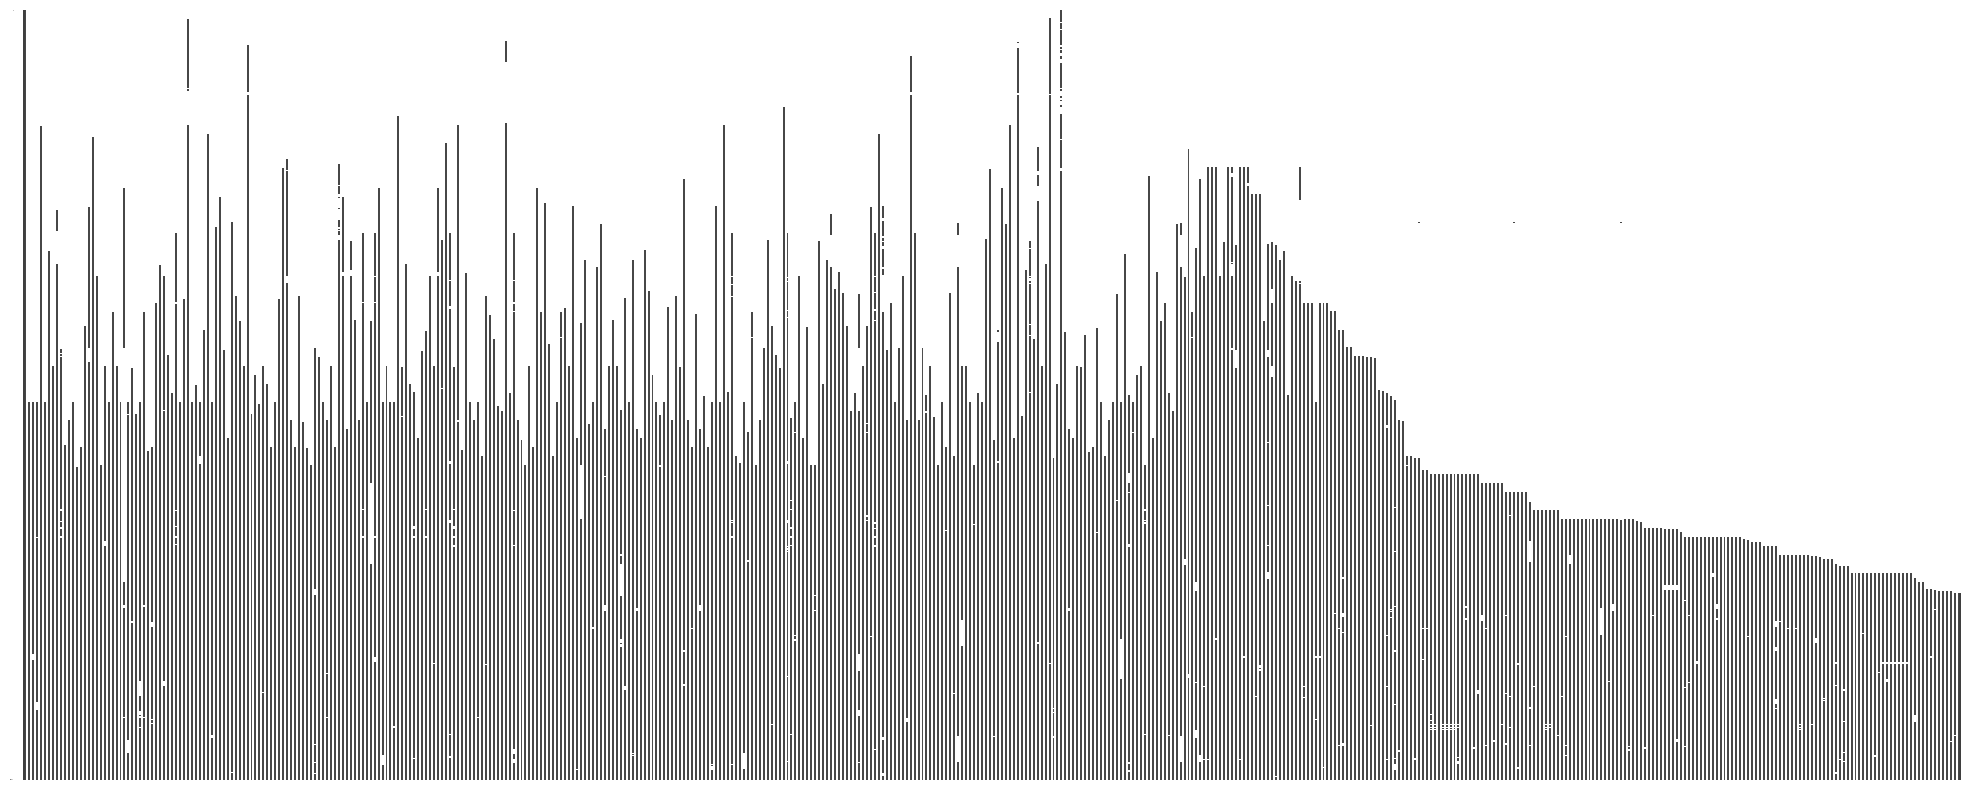

In [98]:
msno.matrix(ts_df_selected, sparkline=False, fontsize = 0)
plt.show()

## Exploratory Data Analysis

First, we'll plot a few time series to verify that the previous data processing was successful.

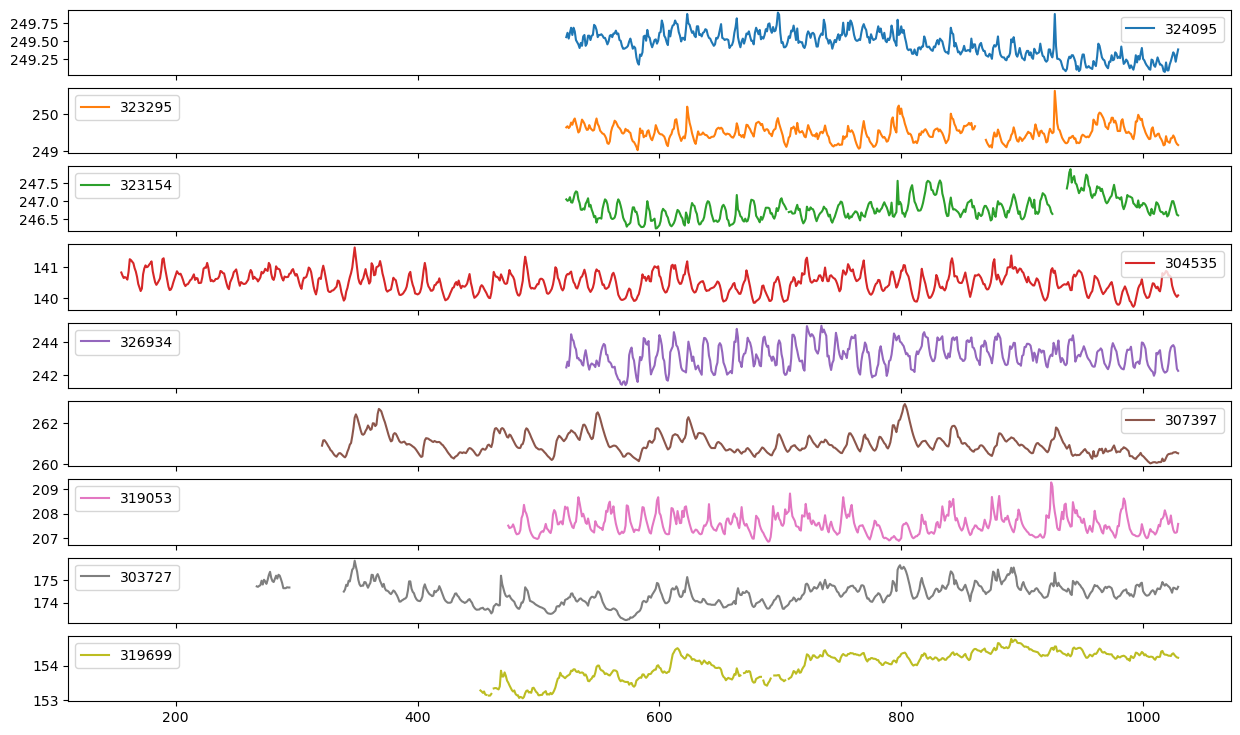

In [14]:
sample_columns = ts_df_selected.columns[:10]
ts_df_selected[sample_columns].plot(subplots=True, layout=(10, 1), figsize=(15, 10))
plt.show()

Now, although we assume that the time series will be seasonal, we'll verify it by taking an example and applying the autocorrelation function.

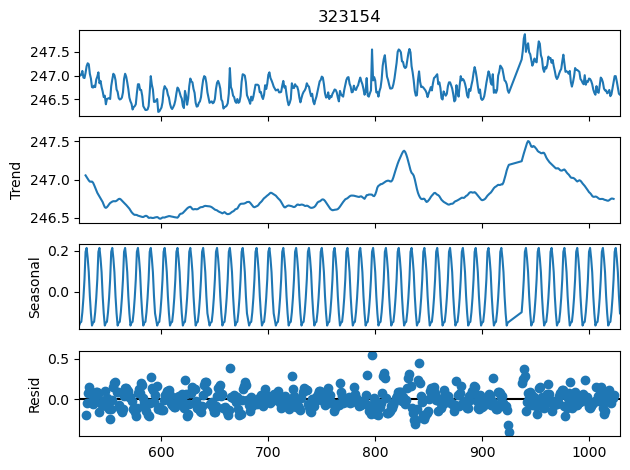

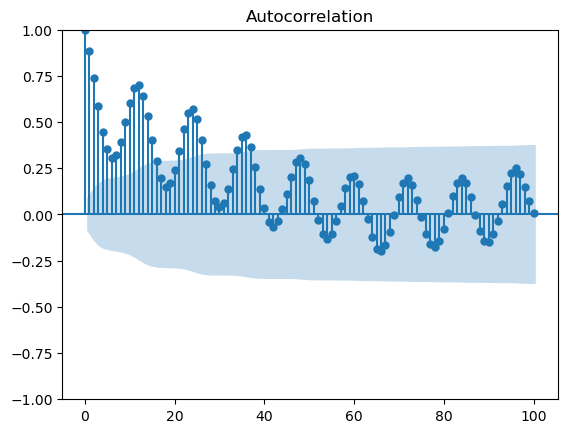

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

# Select a time series for decomposition
series = ts_df_selected[sample_columns[3]].dropna()
result = seasonal_decompose(series, model='additive', period=12)
result.plot()
plt.show()

# Verify the period with the autocorrelation function (ACF)
plot_acf(series.dropna(), lags=100)
plt.show()


As we expected, the series exhibits strong annual seasonality over time.

## Building the dataset for training and validating


Thfollowing e functild taske the number of past observations (`p`) and the number of future steps to predict (`s`) as input. It will iterate through each column of thtime series e dataset, starting from the earliest available data, and generate the following variables for each:

- `loc`: the name of the column (location)
- `date`: the date corresponding to `step_1`
- `lag_p, lag_p-1, ..., lag_1`: the past `p` observations (lags)
- `step_1, step_2, ..., step_s`: the future `s` steps to predict

The resulting DataFrame will contain these variawills and can be used to train machine learninin future stages of the projectfctively.


In [100]:
def create_training_data(df, future_threshold=0.85, past_threshold=0.70, future_window=26, past_window=50):
    """
    Creates a DataFrame for training time series prediction models, applying conditions on the amount 
    of non-NaN values within both the future and past windows.

    The function also generates historical and aggregated variables that could be useful for predicting future steps.

    Parameters:
    df (pd.DataFrame): Original DataFrame containing a 'datetime' column and location code columns.
    future_threshold (float): Minimum proportion of non-NaN values required in the future window.
    past_threshold (float): Minimum proportion of non-NaN values required in the past window.
    future_window (int): Size of the future window.
    past_window (int): Size of the past window.

    Returns:
    pd.DataFrame: DataFrame with variables lag_p, lag_p-1, ..., lag_1 and step_1, step_2, ..., step_s for each location,
                  along with additional historical and aggregated features.
    """

    returned_df = pd.DataFrame()

    # Define past and future column names
    past_columns = [f'lag_{i}' for i in range(past_window, 0, -1)]
    future_columns = [f'step_{i}' for i in range(1, future_window + 1)]
    extra_cols = ["id_loc", "datetime", "hist_mean", "hist_max", "hist_min", "hist_std", "hist_vc", "mean_past_year", 
                  "max_past_year", "min_past_year", "mean_past_quarter", "max_past_quarter", "min_past_quarter", 
                  "pct_diff_meanlast12_meanhist", 'otm_hist_0', 'otm_hist_1', 'otm_hist_2', 'otm_hist_3', 'otm_hist_4', 
                  'otm_hist_5', 'otm_hist_6', 'otm_hist_7', 'otm_hist_8', 'otm_hist_9', 'otm_hist_10', 'otm_hist_11']
    
    # Loop through each location column
    for i in range(1, df.shape[1]):
        print(f"Processing location {i}/{df.shape[1] - 1}")
        
        # Iterate over each time point, ensuring sufficient past and future data
        for j in range(df.iloc[:, i].first_valid_index() + past_window, df.shape[0] - future_window):
            
            # Select the window of observations for lags and future steps
            new_obs = df.iloc[(j-past_window):(j+future_window), i].copy()

            # Check if the selected window has enough non-NaN values
            past_condition = sum(np.isnan(new_obs[:past_window])) <= (1-past_threshold)*past_window
            future_condition = sum(np.isnan(new_obs[-future_window:])) <= (1-future_threshold)*future_window

            if past_condition and future_condition:
                # Impute missing values in the past window
                new_obs[:past_window] = new_obs[:past_window].fillna(new_obs[:past_window].mean())

                # Generate additional historical and aggregated variables for each location
                id_loc = pd.DataFrame({0: [df.columns[i]]})
                datetime = pd.DataFrame({0: [df.iloc[j, 0]]})
                hist_mean = pd.DataFrame({0: [df.iloc[:j, i].mean()]})
                hist_max = pd.DataFrame({0: [df.iloc[:j, i].max()]})
                hist_min = pd.DataFrame({0: [df.iloc[:j, i].min()]})
                hist_std = pd.DataFrame({0: [df.iloc[:j, i].std()]})
                hist_vc = hist_std / hist_mean  # Coefficient of variation
                mean_past_year = pd.DataFrame({0: [df.iloc[j-12:j, i].mean()]})
                max_past_year = pd.DataFrame({0: [df.iloc[j-12:j, i].max()]})
                min_past_year = pd.DataFrame({0: [df.iloc[j-12:j, i].min()]})
                mean_past_quarter = pd.DataFrame({0: [df.iloc[j-3:j, i].mean()]})
                max_past_quarter = pd.DataFrame({0: [df.iloc[j-3:j, i].max()]})
                min_past_quarter = pd.DataFrame({0: [df.iloc[j-3:j, i].min()]})
                pct_diff_meanlast12_meanhist = 1 - mean_past_year / hist_mean

                # Generate historical data for the same month in previous years (otm_hist_{a})
                otm_hist_dict = {}
                for a in range(12):
                    otm = []
                    k = j - 12 + a
                    while k > df.iloc[:, i].first_valid_index():
                        otm.append(df.iloc[k, i])
                        k -= 12
                    otm_hist_dict[f'otm_hist_{a}'] = pd.DataFrame({0: [np.nanmean(otm)]})
                
                # Concatenate all generated variables
                new_obs = pd.concat([new_obs, id_loc, datetime, hist_mean, hist_max, hist_min, hist_std, hist_vc, 
                                     mean_past_year, max_past_year, min_past_year, mean_past_quarter, max_past_quarter, 
                                     min_past_quarter, pct_diff_meanlast12_meanhist, 
                                     otm_hist_dict['otm_hist_0'], otm_hist_dict['otm_hist_1'], otm_hist_dict['otm_hist_2'], 
                                     otm_hist_dict['otm_hist_3'], otm_hist_dict['otm_hist_4'], otm_hist_dict['otm_hist_5'], 
                                     otm_hist_dict['otm_hist_6'], otm_hist_dict['otm_hist_7'], otm_hist_dict['otm_hist_8'], 
                                     otm_hist_dict['otm_hist_9'], otm_hist_dict['otm_hist_10'], otm_hist_dict['otm_hist_11']], 
                                    ignore_index=True)
                
                # Append the result to the final DataFrame
                returned_df = pd.concat([returned_df, new_obs.reset_index(drop=True)], axis=1)

    # Final adjustments and return
    returned_df = returned_df.T.reset_index(drop=True)
    returned_df.columns = past_columns + future_columns + extra_cols

    return returned_df

In [ ]:
training_data_df = create_training_data(ts_df_selected, future_window=26, past_window=50)

In [102]:
#training_data_df.to_csv('full_training_data_df_stage1.csv')

In [4]:
def increment_month(date_str, months_to_add):
    """
    Increment a given date by a specified number of months.

    Parameters:
    date_str (str): Date in the format 'year-day-month' (e.g., '2024-15-03').
    months_to_add (int): Number of months to add to the date.

    Returns:
    str: The new date after adding the specified number of months, in the format 'year-day-month'.
    """
    year, day, month = map(int, date_str.split('-'))
    
    month += months_to_add
    
    while month > 12:
        month -= 12
        year += 1
    
    new_date_str = f"{year}-{day:02d}-{month:02d}"
    
    return new_date_str

In [105]:
def create_taikai_test_data(df, future_threshold=0.85, past_threshold=0.70, future_window=26, past_window=50):
    """
    This function is nearly identical to the one used to build the training and validation DataFrame, 
    but it is adapted for generating prediction data for the deliverable.

    Parameters:
    df (pd.DataFrame): Original DataFrame containing a 'datetime' column and location code columns.
    future_threshold (float): Minimum proportion of non-NaN values required in the future window.
    past_threshold (float): Minimum proportion of non-NaN values required in the past window.
    future_window (int): Size of the future window.
    past_window (int): Size of the past window.

    Returns:
    pd.DataFrame: DataFrame with variables lag_p, lag_p-1, ..., lag_1 and step_1, step_2, ..., step_s for each location,
                  along with additional historical and aggregated features.
    """

    # Find the last date in the 'datetime' column
    last_date = df['datetime'].iloc[-1]
    
    # Generate the new dates by incrementing months
    new_dates = [increment_month(last_date, i) for i in range(1, future_window + 1)]
    
    # Create a new DataFrame for the future data with placeholder values
    new_rows = pd.DataFrame(9999, index=range(future_window), columns=df.columns)
    
    # Fill the 'datetime' column with the new dates
    new_rows['datetime'] = new_dates
    df = pd.concat([df, new_rows], ignore_index=True)

    returned_df = pd.DataFrame()

    # Define column names for past and future windows
    past_columns = [f'lag_{i}' for i in range(past_window, 0, -1)]
    future_columns = [f'step_{i}' for i in range(1, future_window + 1)]
    extra_cols = ["id_loc", "datetime", "hist_mean", "hist_max", "hist_min", "hist_std", "hist_vc", "mean_past_year", 
                  "max_past_year", "min_past_year", "mean_past_quarter", "max_past_quarter", "min_past_quarter", 
                  "pct_diff_meanlast12_meanhist", 'otm_hist_0', 'otm_hist_1', 'otm_hist_2', 'otm_hist_3', 'otm_hist_4', 
                  'otm_hist_5', 'otm_hist_6', 'otm_hist_7', 'otm_hist_8', 'otm_hist_9', 'otm_hist_10', 'otm_hist_11']
    
    # Loop through each location column
    for i in range(1, df.shape[1]):
        print(f"Processing location {i}/{df.shape[1] - 1}")
        for j in range(df.shape[0] - future_window, df.shape[0] - future_window + 1):
            # Select the observation window
            new_obs = df.iloc[(j-past_window):(j+future_window), i].copy()

            # Check if the past and future windows meet the NaN threshold conditions
            past_condition = sum(np.isnan(new_obs[:past_window])) <= (1-past_threshold) * past_window
            future_condition = sum(np.isnan(new_obs[-future_window:])) <= (1-future_threshold) * future_window

            # Impute NaN values in the past window
            new_obs[:past_window] = new_obs[:past_window].fillna(new_obs[:past_window].mean())

            # Add historical and aggregated variables
            id_loc = pd.DataFrame({0: [df.columns[i]]})
            datetime = pd.DataFrame({0: [df.iloc[j, 0]]})
            hist_mean = pd.DataFrame({0: [df.iloc[:j, i].mean()]})
            hist_max = pd.DataFrame({0: [df.iloc[:j, i].max()]})
            hist_min = pd.DataFrame({0: [df.iloc[:j, i].min()]})
            hist_std = pd.DataFrame({0: [df.iloc[:j, i].std()]})
            hist_vc = hist_std / hist_mean  # Coefficient of variation
            mean_past_year = pd.DataFrame({0: [df.iloc[j-12:j, i].mean()]})
            max_past_year = pd.DataFrame({0: [df.iloc[j-12:j, i].max()]})
            min_past_year = pd.DataFrame({0: [df.iloc[j-12:j, i].min()]})
            mean_past_quarter = pd.DataFrame({0: [df.iloc[j-3:j, i].mean()]})
            max_past_quarter = pd.DataFrame({0: [df.iloc[j-3:j, i].max()]})
            min_past_quarter = pd.DataFrame({0: [df.iloc[j-3:j, i].min()]})
            pct_diff_meanlast12_meanhist = 1 - mean_past_year / hist_mean

            # Create historical data for the same month in previous years (otm_hist_{a})
            otm_hist_dict = {}
            for a in range(12):
                otm = []
                k = j - 12 + a
                while k > df.iloc[:, i].first_valid_index():
                    otm.append(df.iloc[k, i])
                    k -= 12
                otm_hist_dict[f'otm_hist_{a}'] = pd.DataFrame({0: [np.nanmean(otm)]})
            
            # Concatenate all variables
            new_obs = pd.concat([new_obs, id_loc, datetime, hist_mean, hist_max, hist_min, hist_std, hist_vc, 
                                 mean_past_year, max_past_year, min_past_year, mean_past_quarter, max_past_quarter, 
                                 min_past_quarter, pct_diff_meanlast12_meanhist, 
                                 otm_hist_dict['otm_hist_0'], otm_hist_dict['otm_hist_1'], otm_hist_dict['otm_hist_2'], 
                                 otm_hist_dict['otm_hist_3'], otm_hist_dict['otm_hist_4'], otm_hist_dict['otm_hist_5'], 
                                 otm_hist_dict['otm_hist_6'], otm_hist_dict['otm_hist_7'], otm_hist_dict['otm_hist_8'], 
                                 otm_hist_dict['otm_hist_9'], otm_hist_dict['otm_hist_10'], otm_hist_dict['otm_hist_11']], 
                                ignore_index=True)
            
            # Append to the result DataFrame
            returned_df = pd.concat([returned_df, new_obs.reset_index(drop=True)], axis=1)

    # Final adjustments and return
    returned_df = returned_df.T.reset_index(drop=True)
    returned_df.columns = past_columns + future_columns + extra_cols

    return returned_df

In [ ]:
taikai_test = create_taikai_test_data(ts_df_selected, future_window=26, past_window=50)

In [107]:
taikai_test.head()

,lag_50,lag_49,lag_48,lag_47,lag_46,lag_45,lag_44,lag_43,lag_42,lag_41,lag_40,lag_39,lag_38,lag_37,lag_36,lag_35,lag_34,lag_33,lag_32,lag_31,lag_30,lag_29,lag_28,lag_27,lag_26,lag_25,lag_24,lag_23,lag_22,lag_21,lag_20,lag_19,lag_18,lag_17,lag_16,lag_15,lag_14,lag_13,lag_12,lag_11,lag_10,lag_9,lag_8,lag_7,lag_6,lag_5,lag_4,lag_3,lag_2,lag_1,step_1,step_2,step_3,step_4,step_5,step_6,step_7,step_8,step_9,step_10,step_11,step_12,step_13,step_14,step_15,step_16,step_17,step_18,step_19,step_20,step_21,step_22,step_23,step_24,step_25,step_26,id_loc,datetime,hist_mean,hist_max,hist_min,hist_std,hist_vc,mean_past_year,max_past_year,min_past_year,mean_past_quarter,max_past_quarter,min_past_quarter,pct_diff_meanlast12_meanhist,otm_hist_0,otm_hist_1,otm_hist_2,otm_hist_3,otm_hist_4,otm_hist_5,otm_hist_6,otm_hist_7,otm_hist_8,otm_hist_9,otm_hist_10,otm_hist_11
0,249.28,249.26,249.42,249.29,249.18,249.2,249.24,249.22,249.17,249.12,249.16,249.13,249.1,249.17,249.3,249.2,249.29,249.24,249.32,249.4,249.25,249.23,249.19,249.16,249.14,249.11,249.1,249.24,249.23,249.16,249.14,249.2,249.27,249.22,249.17,249.17,249.15,249.08,249.07,249.2,249.09,249.09,249.17,249.22,249.28,249.34,249.31,249.21,249.3,249.38,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,324095,2022-01-01,249.446667,249.89,249.07,0.171899,0.000689,249.221667,249.38,249.07,249.296667,249.38,249.21,0.000902,249.413415,249.409048,249.430714,249.457857,249.485952,249.527143,249.504048,249.477857,249.445238,249.414048,249.398571,249.392857
1,249.54,249.54,249.81,249.86,249.68,249.57,249.49,249.49,249.52,249.48,249.46,249.37,249.32,249.48,249.8,249.8,249.98,249.91,249.84,249.87,249.69,249.6,249.5,249.43,249.37,249.32,249.33,249.59,249.64,249.48,249.39,249.41,249.46,249.47,249.37,249.32,249.25,249.15,249.17,249.4,249.27,249.24,249.22,249.34,249.35,249.42,249.36,249.25,249.19,249.16,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,323295,2022-01-01,249.495,250.63,249.02,0.215217,0.000863,249.280833,249.42,249.16,249.2,249.25,249.16,0.000858,249.4245,249.496829,249.529268,249.586098,249.557805,249.592927,249.569268,249.556585,249.496667,249.41,249.373571,249.349762
2,247.08,247.04,247.1,246.87,246.77,246.86,246.98,247.16,247.12,247.12,247.1,247.08,246.93,246.9,246.85,246.82,247.01,246.81,246.88,246.87,246.94,246.93,246.89,246.82,246.71,246.64,246.6,246.78,246.66,246.64,246.79,246.96,246.93,246.86,246.73,246.69,246.69,246.63,246.65,246.7,246.57,246.61,246.74,246.87,246.99,246.99,246.88,246.75,246.62,246.6,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,323154,2022-01-01,246.801016,247.87,246.24,0.292608,0.001186,246.7475,246.99,246.57,246.656667,246.75,246.6,0.000217,246.645385,246.612439,246.67,246.682381,246.726585,246.817805,246.949268,247.033415,246.991707,246.926829,246.828049,246.717805
3,139.79,139.85,140.04,140.21,140.29,140.38,140.29,140.16,140.05,139.91,139.87,139.77,139.72,139.78,139.96,140.15,140.32,140.41,140.46,140.61,140.38,140.18,140.09,140.01,140.01,140.04,140.17,140.33,140.48,140.47,140.38,140.32,140.37,140.26,140.22,140.42,140.81,140.75,140.8,140.88,140.85,140.73,140.73,140.68,140.41,140.27,140.16,140.09,140.04,140.09,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,9999.0,304535,2022-01-01,140.517489,141.64,139.72,0.316165,0.00225,140.4775,140.88,140.04,140.073333,140.09,140.04,0.000285,140.526389,140.627083,140.7325,140.800278,140.721389,140.614384,140.475342,140.383151,140.30863,140.279452,140.332055,140.416164
4,242.66,242.53,242.42,242.37,242.35,242.69,

In [108]:
taikai_test.to_csv("taikai_test_data.csv", index = False)

In [8]:
#taikai_test = pd.read_csv('taikai_test_data.csv')
#training_data_df = pd.read_csv('full_training_data_df_stage1.csv')

## Feature Engineering

Now, we concatenate both the train/validation and test data to perform joint feature engineering. We will generate a series of variables that we believe could be useful for predicting the future steps.

In [12]:
training_data_df = pd.concat([training_data_df, taikai_test], axis=0).reset_index(drop = True).drop(columns = ['Unnamed: 0'])

#### New features based on datetime

In [18]:
import holidays

# Modify the 'datetime' column to retain only the first 10 characters (YYYY-MM-DD format)
training_data_df['datetime'] = training_data_df['datetime'].str[:10]

# Extract 'Year' and 'Month' from the 'datetime' column
training_data_df['Year'] = training_data_df['datetime'].str[:4].astype(int)
training_data_df['Month'] = training_data_df['datetime'].str[8:10].astype(int)

# Create a sinusoidal transformation for the 'Month' column to capture cyclical patterns
training_data_df['Month_sin'] = np.sin(2 * np.pi * training_data_df['Month'] / 12)

# Create dummy variables for each season based on the 'Month' value
training_data_df['is_Winter'] = training_data_df['Month'].isin([12, 1, 2, 3])
training_data_df['is_Spring'] = training_data_df['Month'].isin([4, 5])
training_data_df['is_Summer'] = training_data_df['Month'].isin([6, 7, 8])
training_data_df['is_Autumn'] = training_data_df['Month'].isin([9, 10, 11])

# Holidays-related variables
# Load Austrian public holidays for the relevant years
austria_holidays = holidays.Austria(years=training_data_df['Year'].unique())

# Create a 'year_month' column by combining 'Year' and 'Month' to represent each month
training_data_df['year_month'] = pd.to_datetime(training_data_df[['Year', 'Month']].assign(DAY=1))

# Create a DataFrame that counts the number of public holidays for each 'year_month'
holidays_count = pd.DataFrame([
    {
        'year_month': pd.Timestamp(year, month, 1),
        'BankHolidays': sum(1 for date in austria_holidays if date.year == year and date.month == month)
    }
    for year in training_data_df['Year'].unique()
    for month in range(1, 13)
])

# Merge the public holiday count into the original DataFrame by 'year_month'
training_data_df = training_data_df.merge(holidays_count, on='year_month', how='left')

# Add columns for the number of public holidays in months -2, -1, +1, ..., +24 relative to the current month
for i in range(-2, 25):
    col_name = f'BankHolidays_Month_{i}'
    training_data_df[col_name] = training_data_df['year_month'].apply(
        lambda x: holidays_count.set_index('year_month').BankHolidays.get(x + pd.DateOffset(months=i), 0)
    )

# Drop the 'datetime' and 'year_month' columns as they are no longer needed
training_data_df = training_data_df.drop(columns=['datetime', 'year_month'])

#### New features based on zone

In [ ]:
# Extract 'zones' data
zones_df = data_aux1[['dbmsnr', 'hzbnr01']]

# Convert 'dbmsnr' and 'hzbnr01' columns to string type for consistency
zones_df['dbmsnr'] = zones_df['dbmsnr'].astype(str)
zones_df['hzbnr01'] = zones_df['hzbnr01'].astype(str)

# Filter rows where 'hzbnr01' values are in the target locations list
zones_df = zones_df[zones_df.hzbnr01.isin(target_locations)]

# Extract the first character from 'dbmsnr' and convert it back to an integer
zones_df['dbmsnr'] = zones_df['dbmsnr'].str[0].astype(int)

# Define a mapping for 'dbmsnr' codes to corresponding Austrian regions
mapping = {
    1: 'Burgenland',
    2: 'Kärnten',
    3: 'Niederösterreich',
    4: 'Oberösterreich',
    5: 'Salzburg',
    6: 'Steiermark',
    7: 'Tirol',
    8: 'Vorarlberg',
    9: 'Wien'
}

# Assuming that 'dbmsnr' values are within the range of 1 to 9,
# map the 'dbmsnr' codes to region names using the predefined mapping
zones_df['Region'] = zones_df['dbmsnr'].map(mapping)

# Create a dictionary where 'hzbnr01' serves as the key and 'Region' as the value
zones_dict = zones_df.set_index('hzbnr01')['Region'].to_dict()

In [27]:
# Add a new column 'Zone' to the DataFrame by mapping 'id_loc' to the corresponding region using the 'zones_dict'
training_data_df['Zone'] = training_data_df['id_loc'].map(zones_dict)

# For each zone, create a new boolean column indicating whether the row belongs to that specific zone
zones = set(zones_dict.values()) 
for zone in zones:
    training_data_df[f'is_{zone}'] = training_data_df['Zone'] == zone

In [53]:
## To add zone-level aggregates:

# Initialize lists to store aggregated values for each row
zone_mean = []
zone_mean_hist = []
zone_max = []
zone_max_hist = []
zone_min = []
zone_min_hist = []
zone_std_hist = []
zone_vc_hist = []

# Iterate over each row of the DataFrame
for index, row in training_data_df.iterrows():
    # Find the subset of observations that match the current row's 'Year', 'Month', and 'Zone'
    subset = training_data_df[
        (training_data_df['Year'] == row['Year']) & 
        (training_data_df['Month'] == row['Month']) & 
        (training_data_df['Zone'] == row['Zone'])
    ]

    # Append aggregated statistics for the 'mean_past_year', 'max_past_year', and 'min_past_year' columns
    zone_mean.append(subset.mean_past_year.mean())
    zone_max.append(subset.max_past_year.max())
    zone_min.append(subset.min_past_year.min())

    # Append aggregated historical statistics for 'hist_mean', 'hist_max', and 'hist_min'
    zone_mean_hist.append(subset.hist_mean.mean())
    zone_max_hist.append(subset.hist_max.max())
    zone_min_hist.append(subset.hist_min.min())

    # Append aggregated statistics for historical standard deviation and coefficient of variation (VC)
    zone_std_hist.append(subset.hist_std.mean())
    zone_vc_hist.append(subset.hist_vc.mean())

# Add the aggregated values as new columns to the DataFrame
training_data_df['zone_mean'] = zone_mean
training_data_df['zone_max'] = zone_max
training_data_df['zone_min'] = zone_min
training_data_df['zone_mean_hist'] = zone_mean_hist
training_data_df['zone_max_hist'] = zone_max_hist
training_data_df['zone_min_hist'] = zone_min_hist
training_data_df['zone_std_hist'] = zone_std_hist
training_data_df['zone_vc_hist'] = zone_vc_hist

#### New features from parsing the original .txt files

In [ ]:
## Datos de altitudes y profundidades parseados de los .txt
terrain_elevation_dict = {k: float(v.replace(',', '.').strip()) for k, v in terrain_elevation_dict.items()}
# Crear la nueva columna en el DataFrame mapeando los valores del diccionario usando 'id_loc'
training_data_df['terrain_elevation'] = training_data_df['id_loc'].map(terrain_elevation_dict)

measurement_point_elevation_dict = {k: float(v.replace(',', '.').strip()) for k, v in measurement_point_elevation_dict.items()}
training_data_df['measurement_point_elevation'] = training_data_df['id_loc'].map(measurement_point_elevation_dict)

bottom_level_dict = {k: float(v.replace(',', '.').strip()) for k, v in bottom_level_dict.items()}
training_data_df['bottom_level'] = training_data_df['id_loc'].map(bottom_level_dict)

In [ ]:
def dms_to_decimal_from_string(dms):
    """
    Convert a coordinate in DMS (degrees, minutes, seconds) format from a string to decimal format.

    Parameters:
    dms (str): A string containing latitude and longitude in DMS format, 
               where latitude and longitude are separated by a space.

    Returns:
    str: A string representing the latitude and longitude in decimal format, separated by a comma.
    """
    
    # Split the input string into latitude and longitude
    lon_dms, lat_dms = dms.split()

    # Extract only the digits from the DMS strings and concatenate them
    lon_numbers = ''.join(filter(str.isdigit, lon_dms))
    lat_numbers = ''.join(filter(str.isdigit, lat_dms))

    # Convert the extracted numbers into degrees, minutes, and seconds for longitude
    lon_degrees = int(lon_numbers[:2])
    lon_minutes = int(lon_numbers[2:4])
    lon_seconds = int(lon_numbers[4:])

    # Convert the extracted numbers into degrees, minutes, and seconds for latitude
    lat_degrees = int(lat_numbers[:2])
    lat_minutes = int(lat_numbers[2:4])
    lat_seconds = int(lat_numbers[4:])

    # Convert DMS values to decimal format for both longitude and latitude
    lon_decimal = lon_degrees + lon_minutes / 60 + lon_seconds / 3600
    lat_decimal = lat_degrees + lat_minutes / 60 + lat_seconds / 3600

    # Apply a negative sign if the latitude is in the Southern Hemisphere or the longitude is in the Western Hemisphere
    if 'S' in lat_dms:
        lat_decimal = -lat_decimal
    if 'W' in lon_dms:
        lon_decimal = -lon_decimal

    # Return the decimal coordinates as a string
    return f"{lat_decimal}, {lon_decimal}"

# Convert all coordinates in the dictionary from DMS to decimal format (loc_coord_dict is generated in the first .txt parsing process)
loc_coord_dict = {key: dms_to_decimal_from_string(value) for key, value in loc_coord_dict.items()}

We save the dictionary containing all the diferent acquifers' coordinates since we will use them to obtain exogenous variables based on location

In [ ]:
import json

with open('loc_coords.json', 'w') as json_file:
    json.dump(loc_coord_dict, json_file)

We also save latitude and longitude for each location.

In [ ]:
def get_latitude(coord_string):
    return float(coord_string.split(', ')[0])

def get_longitude(coord_string):
    return float(coord_string.split(', ')[1])

# Latitude and longitude variables are created
training_data_df['latitude'] = training_data_df['id_loc'].map(lambda x: get_latitude(loc_coord_dict[x]))
training_data_df['longitude'] = training_data_df['id_loc'].map(lambda x: get_longitude(loc_coord_dict[x]))

In [ ]:
coord_df = training_data_df[['id_loc', 'latitude', 'longitude']].drop_duplicates()
coord_df.to_csv('gw_coordinates_df.csv', index=False)

In [44]:
training_data_df.shape

(214474, 159)

## Final processing steps

Since many exogenous variables are very difficult to find for dates previous to 1960 we choose to work with data only from 1960 onward. Discarding the rest of observations only results in a 1% decrease of total rows in the data.

In [45]:
training_data_df = training_data_df[training_data_df.Year > 1959]

#### Imputation of missing values in the newly generated features

In [46]:
# Definir las columnas que necesitan ser rellenadas
columns_to_fill = [
    'min_past_quarter', 'max_past_quarter', 'mean_past_quarter', 
    'mean_past_year', 'max_past_year', 'min_past_year', 'pct_diff_meanlast12_meanhist'
]

# Iterar por cada columna para rellenar los NaNs
for column in columns_to_fill:
    # Para cada fila, filtrar años anteriores y meses anteriores
    for idx, row in training_data_df.loc[training_data_df[column].isna()].iterrows():
        year = row['Year']
        month = row['Month']
        
        # Filtrar observaciones históricas
        historical_data = training_data_df[
            (training_data_df['Year'] < year) | 
            ((training_data_df['Year'] == year) & (training_data_df['Month'] < month))
        ][column]
        
        # Calcular la media histórica
        historical_mean = historical_data.mean()
        
        # Rellenar con la media histórica
        training_data_df.at[idx, column] = historical_mean

In [ ]:
training_data_df.to_csv('full_training_data_df_stage4_with_taikai.csv')